In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath("../.."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from src.utils import *
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [23]:
test_labels = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/labels/test_labels.npy')
train_tracks = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/data/tracks/train_tracks.npy")
train_labels = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/data/labels/train_labels.npy")
test_tracks = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/data/tracks/test_tracks.npy")

# Extract original features (13 features)
train_tracks_features_orig = train_tracks[:, 0, 4:17] 
test_tracks_features_orig = test_tracks[:, 0, 4:17]

# Calculate FRET_std (coefficient of variation)
# FRET_std = sqrt(CFP_std^2 + YFP_std^2) / (CFP_avg + YFP_avg)
# CFP_std is at index 3, YFP_std is at index 4, CFP_avg is at index 1, YFP_avg is at index 2
fret_std_train = np.sqrt(train_tracks_features_orig[:, 3]**2 + train_tracks_features_orig[:, 4]**2) / (train_tracks_features_orig[:, 1] + train_tracks_features_orig[:, 2])
fret_std_test = np.sqrt(test_tracks_features_orig[:, 3]**2 + test_tracks_features_orig[:, 4]**2) / (test_tracks_features_orig[:, 1] + test_tracks_features_orig[:, 2])

# Insert FRET_std as the second feature (index 1)
train_tracks_features = np.insert(train_tracks_features_orig, 1, fret_std_train, axis=1)
test_tracks_features = np.insert(test_tracks_features_orig, 1, fret_std_test, axis=1)

print(f"Original train features shape: {train_tracks_features_orig.shape}")
print(f"New train features shape: {train_tracks_features.shape}")
print(f"Original test features shape: {test_tracks_features_orig.shape}")
print(f"New test features shape: {test_tracks_features.shape}")

Original train features shape: (1108, 13)
New train features shape: (1108, 14)
Original test features shape: (277, 13)
New test features shape: (277, 14)


/var/folders/ds/_m8m03r135b5r67hc6xgtxt00000gn/T/ipykernel_87253/1319925203.py:13: RuntimeWarning: invalid value encountered in divide
  fret_std_train = np.sqrt(train_tracks_features_orig[:, 3]**2 + train_tracks_features_orig[:, 4]**2) / (train_tracks_features_orig[:, 1] + train_tracks_features_orig[:, 2])


FEATURES:
    "cell_av_FRET_norm", "FRET_std", "CFP_av", "YFP_av", 
    "CFP_std", "YFP_std", "MajorAxisLength", "MinorAxisLength", "Eccentricity", "EquivDiameter", 
    "Perimeter", "INT_av", "Area", "Aspect_Ratio", "mitosis_time", "fate"

In [28]:
# Feature names corresponding to their indices 
feature_names = ["FRET_avg", "FRET_std", "CFP_avg", "YFP_avg", 
                 "CFP_std", "YFP_std", "MajorAxisLength", "MinorAxisLength", 
                 "Eccentricity", "Diameter", "Perimeter", "Intensity_avg", "Area", "Aspect_Ratio"]

# Generate all unique feature pairs (14 choose 2 = 91 combinations)
import itertools
combinations = list(itertools.combinations(range(14), 2))

# Generate formatted output
for i, (f1, f2) in enumerate(combinations, 1):
    print(f" {i}: [{feature_names[f1]}, {feature_names[f2]}]")


 1: [FRET_avg, FRET_std]
 2: [FRET_avg, CFP_avg]
 3: [FRET_avg, YFP_avg]
 4: [FRET_avg, CFP_std]
 5: [FRET_avg, YFP_std]
 6: [FRET_avg, MajorAxisLength]
 7: [FRET_avg, MinorAxisLength]
 8: [FRET_avg, Eccentricity]
 9: [FRET_avg, Diameter]
 10: [FRET_avg, Perimeter]
 11: [FRET_avg, Intensity_avg]
 12: [FRET_avg, Area]
 13: [FRET_avg, Aspect_Ratio]
 14: [FRET_std, CFP_avg]
 15: [FRET_std, YFP_avg]
 16: [FRET_std, CFP_std]
 17: [FRET_std, YFP_std]
 18: [FRET_std, MajorAxisLength]
 19: [FRET_std, MinorAxisLength]
 20: [FRET_std, Eccentricity]
 21: [FRET_std, Diameter]
 22: [FRET_std, Perimeter]
 23: [FRET_std, Intensity_avg]
 24: [FRET_std, Area]
 25: [FRET_std, Aspect_Ratio]
 26: [CFP_avg, YFP_avg]
 27: [CFP_avg, CFP_std]
 28: [CFP_avg, YFP_std]
 29: [CFP_avg, MajorAxisLength]
 30: [CFP_avg, MinorAxisLength]
 31: [CFP_avg, Eccentricity]
 32: [CFP_avg, Diameter]
 33: [CFP_avg, Perimeter]
 34: [CFP_avg, Intensity_avg]
 35: [CFP_avg, Area]
 36: [CFP_avg, Aspect_Ratio]
 37: [YFP_avg, CFP_std]

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# Define config
config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
}

# Set seed
tf.keras.utils.set_random_seed(config['seed'])
np.random.seed(config['seed'])

# All unique feature pairs (14 choose 2 = 91)
feature_pairs = list(itertools.combinations(range(14), 2))
config['n_feature_pairs'] = len(feature_pairs)

# Initialize container for confusion matrices
conf_matrix_tabular = np.zeros((config['n_feature_pairs'], 2, 2))

# Loop over all unique feature combinations
for i, selected_features in enumerate(feature_pairs):
    print(f"Run {i+1}/{config['n_feature_pairs']} — Using features: {selected_features}")

    # Subset the data
    X_train = train_tracks_features[:, selected_features]
    X_test = test_tracks_features[:, selected_features]

    # Train/val split
    X_val, X_test_final, y_val, y_test_final = train_test_split(X_test, test_labels, test_size=0.5, random_state=42)

    # Class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = dict(enumerate(class_weights))

    # Build model
    classifier = complex_mlp_classifier(latent_dim=2)
    classifier.compile(loss='sparse_categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
                       metrics=['accuracy'])

    # Train
    try:
        tf.keras.backend.clear_session()
        history = classifier.fit(
            X_train, train_labels,
            batch_size=config['batch_size'],
            epochs=config['epochs'],
            validation_data=(X_val, y_val),
            class_weight=class_weights,
            verbose=0
        )
    except Exception as e:
        print(f"Continuing training without classification check... {e}")
        # Clean up in case of error
        try:
            del classifier
        except Exception:
            pass
        tf.keras.backend.clear_session()
        history = None

    # Predict
    y_pred = classifier.predict(X_test_final, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_test_final, y_pred_classes)
    cm_normalized = cm / cm.sum(axis=1, keepdims=True)
    conf_matrix_tabular[i] = cm_normalized

# Save results
# np.save("confusion_matrices_all_feature_combinations.npy", conf_matrix_tabular)


Run 1/91 — Using features: (0, 1)


In [ ]:
#np.save("conf_matrices_all_possible_feat_comb.npy", conf_matrix_tabular)

In [106]:
conf_matrix_tabular = np.load("conf_matrices_all_possible_feat_comb.npy")

In [7]:
precision_tabular = np.zeros((conf_matrix_tabular.shape[0]))
accuracy_tabular = np.zeros((conf_matrix_tabular.shape[0]))
false_positives_tabular = np.zeros((conf_matrix_tabular.shape[0]))
false_negatives_tabular = np.zeros((conf_matrix_tabular.shape[0]))

for size in range(conf_matrix_tabular.shape[0]):
    conf_matrix = conf_matrix_tabular[size]
    precision_tabular[size] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
    accuracy_tabular[size] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
    false_positives_tabular[size] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
    false_negatives_tabular[size] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])

In [ ]:
# np.save("precision_2feattabular.npy", precision_tabular)
# np.save("accuracy_2feattabular.npy", accuracy_tabular)
# np.save("false_positives_2feattabular.npy", false_positives_tabular)
# np.save("false_negatives_2feattabular.npy", false_negatives_tabular)

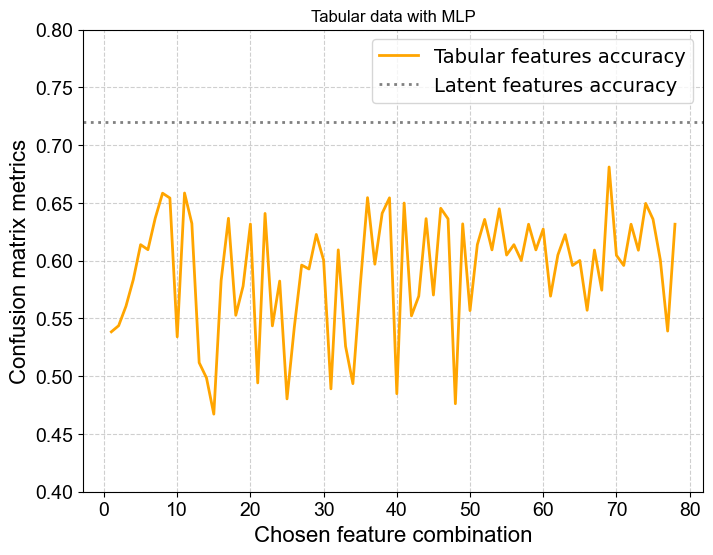

In [8]:
feature_pairs = np.arange(1, 79)

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
#plt.plot(feature_pairs, precision_tabular, color='orange', linewidth=2, label='Precision')

# Accuracy (purple)
plt.plot(feature_pairs, accuracy_tabular, color='orange', linewidth=2, label='Tabular features accuracy')

# Add horizontal dotted line for AICellFate model precision
#plt.axhline(y=0.745, color='orange', linestyle='dotted', linewidth=2, label='AICellFate model precision')
plt.axhline(y=0.72, color='gray', linestyle='dotted', linewidth=2, label='Latent features accuracy') ### this is the mean precision value from AICellFate on the first frame

# # False Positives (green)
# plt.plot(feature_pairs, false_positives_tabular, color='green', linewidth=2, label='False Positives')

# # False Negatives (blue)
# plt.plot(feature_pairs, false_negatives_tabular, color='blue', linewidth=2, label='False Negatives')

# Formatting
plt.xlabel("Chosen feature combination", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix metrics", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.4, 0.8)  # Set y-axis range
plt.title("Tabular data with MLP")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=14)
# Save the figure with high quality
#plt.savefig("accuracy_all_tab_feat_combination.eps", dpi=300, bbox_inches="tight")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


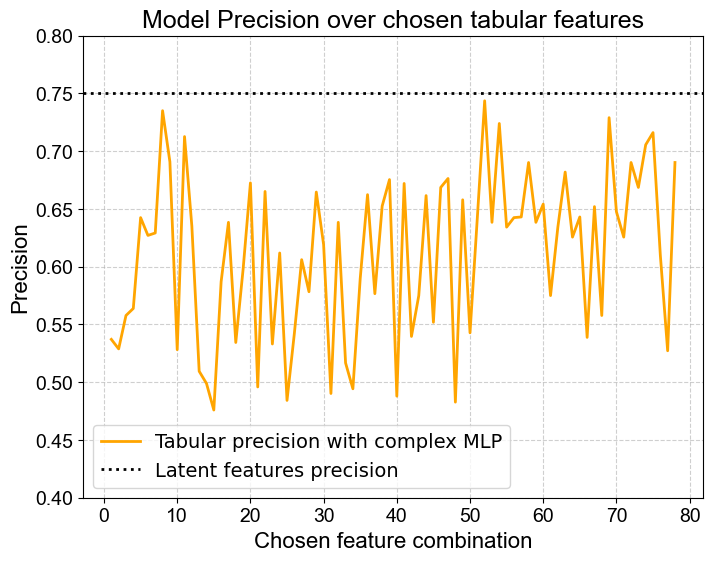

In [116]:
feature_pairs = np.arange(1, 79)

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
plt.plot(feature_pairs, precision_tabular, color='orange', linewidth=2, label='Tabular precision with complex MLP')

# Accuracy (purple)
#plt.plot(feature_pairs, accuracy_tabular, color='orange', linewidth=2, label='Tabular features accuracy')

# Add horizontal dotted line for AICellFate model precision
plt.axhline(y=0.75, color='black', linestyle='dotted', linewidth=2, label='Latent features precision')
#plt.axhline(y=0.72, color='gray', linestyle='dotted', linewidth=2, label='Latent features accuracy') ### this is the mean precision value from AICellFate on the first frame

# # False Positives (green)
# plt.plot(feature_pairs, false_positives_tabular, color='green', linewidth=2, label='False Positives')

# # False Negatives (blue)
# plt.plot(feature_pairs, false_negatives_tabular, color='blue', linewidth=2, label='False Negatives')

# Formatting
plt.xlabel("Chosen feature combination", fontsize=16, fontname="Arial")
plt.ylabel("Precision", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.4, 0.8)  # Set y-axis range
plt.title("Model Precision over chosen tabular features", fontsize=18)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=14)
# Save the figure with high quality
plt.savefig("precision_tabular.eps", dpi=300, bbox_inches="tight")
plt.show()

# Performance with smaller model

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# Define config
config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
}

# Set seed
tf.keras.utils.set_random_seed(config['seed'])
np.random.seed(config['seed'])

# All unique feature pairs (13 choose 2 = 78)
feature_pairs = list(itertools.combinations(range(13), 2))
config['n_feature_pairs'] = len(feature_pairs)

# Initialize container for confusion matrices
conf_matrix_tabular = np.zeros((config['n_feature_pairs'], 2, 2))

# Loop over all unique feature combinations
for i, selected_features in enumerate(feature_pairs):
    print(f"Run {i+1}/{config['n_feature_pairs']} — Using features: {selected_features}")

    # Subset the data
    X_train = train_tracks_features[:, selected_features]
    X_test = test_tracks_features[:, selected_features]

    # Train/val split
    X_val, X_test_final, y_val, y_test_final = train_test_split(X_test, test_labels, test_size=0.5, random_state=42)

    # Class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = dict(enumerate(class_weights))

    # Build model
    classifier = mlp_classifier(latent_dim=2)
    classifier.compile(loss='sparse_categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
                       metrics=['accuracy'])

    # Train
    classifier.fit(X_train, train_labels,
                   batch_size=config['batch_size'],
                   epochs=config['epochs'],
                   validation_data=(X_val, y_val),
                   class_weight=class_weights,
                   verbose=0)

    # Predict
    y_pred = classifier.predict(X_test_final, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_test_final, y_pred_classes)
    cm_normalized = cm / cm.sum(axis=1, keepdims=True)
    conf_matrix_tabular[i] = cm_normalized
    

# Save results
# np.save("confusion_matrices_all_feature_combinations.npy", conf_matrix_tabular)


Run 1/78 — Using features: (0, 1)
Run 2/78 — Using features: (0, 2)
Run 3/78 — Using features: (0, 3)
Run 4/78 — Using features: (0, 4)
Run 5/78 — Using features: (0, 5)
Run 6/78 — Using features: (0, 6)
Run 7/78 — Using features: (0, 7)
Run 8/78 — Using features: (0, 8)
Run 9/78 — Using features: (0, 9)
Run 10/78 — Using features: (0, 10)
Run 11/78 — Using features: (0, 11)
Run 12/78 — Using features: (0, 12)
Run 13/78 — Using features: (1, 2)
Run 14/78 — Using features: (1, 3)
Run 15/78 — Using features: (1, 4)
Run 16/78 — Using features: (1, 5)
Run 17/78 — Using features: (1, 6)
Run 18/78 — Using features: (1, 7)
Run 19/78 — Using features: (1, 8)
Run 20/78 — Using features: (1, 9)
Run 21/78 — Using features: (1, 10)
Run 22/78 — Using features: (1, 11)
Run 23/78 — Using features: (1, 12)
Run 24/78 — Using features: (2, 3)
Run 25/78 — Using features: (2, 4)
Run 26/78 — Using features: (2, 5)
Run 27/78 — Using features: (2, 6)
Run 28/78 — Using features: (2, 7)
Run 29/78 — Using featu

In [ ]:
#np.save("confusion_matrices_small_model_all_features.npy", conf_matrix_tabular)

In [25]:
conf_matrix_tabular = np.load("confusion_matrices_small_model_all_features.npy")

In [29]:
precision_tabular = np.zeros((conf_matrix_tabular.shape[0]))
accuracy_tabular_smallmp = np.zeros((conf_matrix_tabular.shape[0]))
false_positives_tabular = np.zeros((conf_matrix_tabular.shape[0]))
false_negatives_tabular = np.zeros((conf_matrix_tabular.shape[0]))

for size in range(conf_matrix_tabular.shape[0]):
    conf_matrix = conf_matrix_tabular[size]
    precision_tabular[size] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0] + 0.00001)
    accuracy_tabular_smallmp[size] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
    false_positives_tabular[size] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
    false_negatives_tabular[size] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


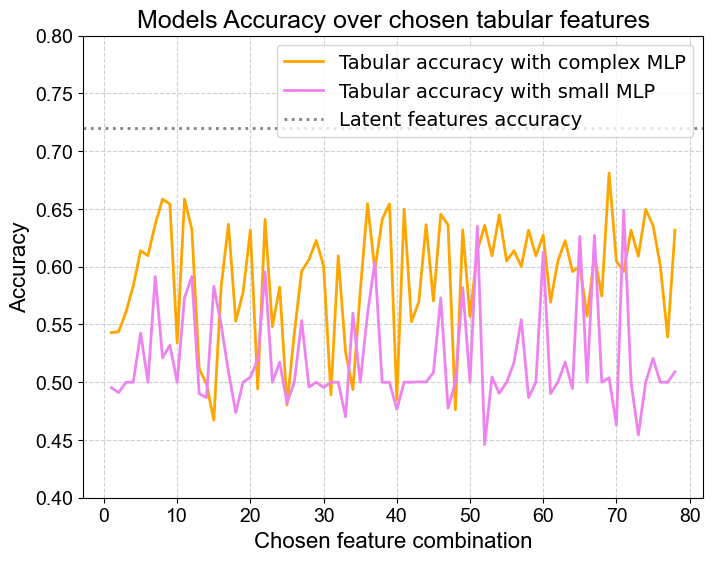

In [ ]:
feature_pairs = np.arange(1, 79)

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
plt.plot(feature_pairs, accuracy_tabular, color='orange', linewidth=2, label='Tabular accuracy with complex MLP')

# Accuracy (purple)
plt.plot(feature_pairs, accuracy_tabular_smallmp, color='violet', linewidth=2, label='Tabular accuracy with small MLP')

# Add horizontal dotted line for AICellFate model precision
#plt.axhline(y=0.745, color='orange', linestyle='dotted', linewidth=2, label='AICellFate model precision')
plt.axhline(y=0.72, color='gray', linestyle='dotted', linewidth=2, label='Latent features accuracy') ### this is the mean precision value from AICellFate on the first frame

# # False Positives (green)
# plt.plot(feature_pairs, false_positives_tabular, color='green', linewidth=2, label='False Positives')

# # False Negatives (blue)
# plt.plot(feature_pairs, false_negatives_tabular, color='blue', linewidth=2, label='False Negatives')

# Formatting
plt.xlabel("Chosen feature combination", fontsize=16, fontname="Arial")
plt.ylabel("Accuracy", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.4, 0.8)  # Set y-axis range
plt.title("Models Accuracy over chosen tabular features", fontsize=18)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=14)
# Save the figure with high quality
#plt.savefig("multi_model_accuracy_tabular.eps", dpi=300, bbox_inches="tight")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


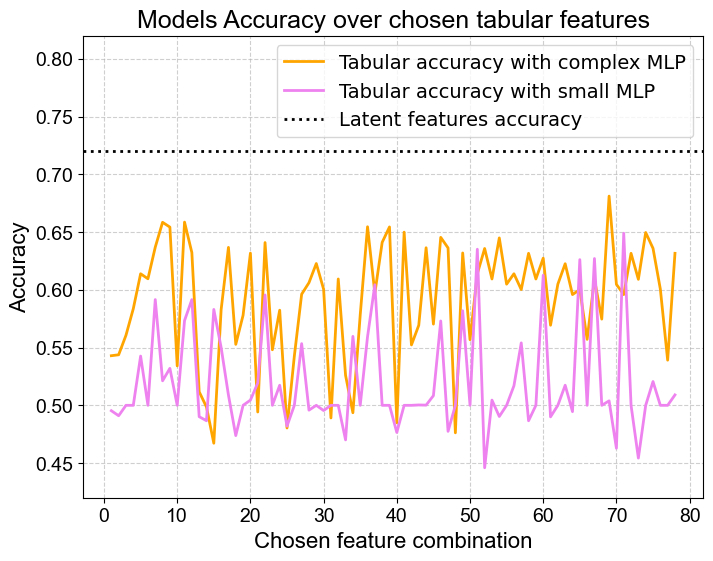

In [ ]:
feature_pairs = np.arange(1, 79)

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
plt.plot(feature_pairs, accuracy_tabular, color='orange', linewidth=2, label='Tabular accuracy with complex MLP')

# Accuracy (purple)
plt.plot(feature_pairs, accuracy_tabular_smallmp, color='violet', linewidth=2, label='Tabular accuracy with small MLP')

# Add horizontal dotted line for AICellFate model precision
#plt.axhline(y=0.745, color='orange', linestyle='dotted', linewidth=2, label='AICellFate model precision')
plt.axhline(y=0.72, color='black', linestyle='dotted', linewidth=2, label='Latent features accuracy') ### this is the mean precision value from AICellFate on the first frame

# # False Positives (green)
# plt.plot(feature_pairs, false_positives_tabular, color='green', linewidth=2, label='False Positives')

# # False Negatives (blue)
# plt.plot(feature_pairs, false_negatives_tabular, color='blue', linewidth=2, label='False Negatives')

# Formatting
plt.xlabel("Chosen feature combination", fontsize=16, fontname="Arial")
plt.ylabel("Accuracy", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.42, 0.82)  # Set y-axis range
plt.title("Models Accuracy over chosen tabular features", fontsize=18)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=14)
# Save the figure with high quality
#plt.savefig("multi_model_accuracy_tabular.eps", dpi=300, bbox_inches="tight")
plt.show()

# All features

In [46]:
np.load("/Users/inescunha/Documents/GitHub/CellFate/data/temporal_study/all_confusion_matrices_tabular.npy")[0]

array([[0.63063063, 0.36936937],
       [0.39285714, 0.60714286]])

In [49]:
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

conf_matrix_tabular = np.zeros((3, 2, 2)) # 3 random states, 11 time points, 2x2 confusion matrix

for seed in [42, 43, 44]:

    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
    class_weights = dict(enumerate(class_weights))

    tf.keras.utils.set_random_seed(seed)
    np.random.seed(seed)

    classifier = complex_mlp_classifier(latent_dim=train_tracks_features[:,:].shape[1]) #[:, [3, 8]] 
    #classifier = simple_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1])

    # Train the classifier
    classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
    classifier.summary()

    x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_features[:,:], test_labels, test_size=0.5, random_state=42) # 42 random state

    history = classifier.fit(train_tracks_features[:,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) 

    y_pred = classifier.predict(x_test_tracks)

    num_classes = 2
    threshold = 0.5
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_tracks, y_pred_classes)

    class_sums = cm.sum(axis=1, keepdims=True)
    conf_matrix_normalized = cm / class_sums

    print(conf_matrix_normalized)

    conf_matrix_tabular[seed-42] = conf_matrix_normalized


Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6917 - loss: 0.7303 - val_accuracy: 0.8043 - val_loss: 0.5844
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6654 - loss: 0.6965 - val_accuracy: 0.7754 - val_loss: 0.6551
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5957 - loss: 0.6978 - val_accuracy: 0.4058 - val_loss: 0.7018
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.5555 - loss: 0.6974 - val_accuracy: 0.4420 - val_loss: 0.7032
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5429 - loss: 0.6692 - val_accuracy: 0.4638 - val_loss: 0.6931
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.5491 - loss: 0.6744 - val_accuracy: 0.4710 - val_loss: 0.6805
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.5491 - loss: 0.6501 - val_accuracy: 0.4855 - val_loss: 0.6691
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.5449 - loss: 0.6531 - val_accuracy: 0.5435 - v

Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5363 - loss: 0.7002 - val_accuracy: 0.2246 - val_loss: 0.8477
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6131 - loss: 0.6519 - val_accuracy: 0.2899 - val_loss: 0.8388
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.6155 - loss: 0.6501 - val_accuracy: 0.3551 - val_loss: 0.8077
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.6157 - loss: 0.6709 - val_accuracy: 0.4275 - val_loss: 0.7589
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6614 - loss: 0.6352 - val_accuracy: 0.4420 - val_loss: 0.7244
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.6810 - loss: 0.6374 - val_accuracy: 0.4420 - val_loss: 0.7057
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.6423 - loss: 0.6290 - val_accuracy: 0.5000 - val_loss: 0.6802
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.6284 - loss: 0.6290 - val_accuracy: 0.5217 -

Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7121 - loss: 0.8704 - val_accuracy: 0.4855 - val_loss: 0.6738
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5939 - loss: 0.7614 - val_accuracy: 0.2464 - val_loss: 0.8232
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.5806 - loss: 0.7104 - val_accuracy: 0.2391 - val_loss: 0.7963
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.5952 - loss: 0.7104 - val_accuracy: 0.3188 - val_loss: 0.7668
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.5358 - loss: 0.6661 - val_accuracy: 0.3623 - val_loss: 0.7414
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5631 - loss: 0.7034 - val_accuracy: 0.4348 - val_loss: 0.7111
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5736 - loss: 0.6862 - val_accuracy: 0.4565 - val_loss: 0.6964
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.5983 - loss: 0.6839 - val_accuracy: 0.4493 - v

In [54]:
tabular_seed42 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_1.0/confusion_matrices_tabular.npy")
tabular_seed43 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed43_1.0/confusion_matrices_tabular.npy")
tabular_seed44 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed44_1.0/confusion_matrices_tabular.npy")
conf_matrix_tabular= np.stack([tabular_seed42, tabular_seed43, tabular_seed44], axis=0)

In [55]:
conf_matrix_tabular

array([[[[0.63963964, 0.36036036],
         [0.32142857, 0.67857143]]],


       [[[0.62162162, 0.37837838],
         [0.25      , 0.75      ]]],


       [[[0.53153153, 0.46846847],
         [0.25      , 0.75      ]]]])

In [52]:
ai4cellfate_seed42 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_1.0/confusion_matrices_cellfate.npy")
ai4cellfate_seed43 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed43_1.0/confusion_matrices_cellfate.npy")
ai4cellfate_seed44 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed44_1.0/confusion_matrices_cellfate.npy")
conf_matrix_ai4cellfate = np.stack([ai4cellfate_seed42, ai4cellfate_seed43, ai4cellfate_seed44], axis=0)

In [61]:
conf_matrix_ai4cellfate.shape

(3, 1, 2, 2)

In [62]:
# get precision and accuracy for both cases

precision_tabular = np.zeros((conf_matrix_tabular.shape[0]))
accuracy_tabular = np.zeros((conf_matrix_tabular.shape[0]))
false_positives_tabular = np.zeros((conf_matrix_tabular.shape[0]))
false_negatives_tabular = np.zeros((conf_matrix_tabular.shape[0]))

for seed in range(conf_matrix_tabular.shape[0]):
    conf_matrix = conf_matrix_tabular[seed][0]
    print(conf_matrix.shape)
    precision_tabular[seed] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
    accuracy_tabular[seed] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
    false_positives_tabular[seed] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
    false_negatives_tabular[seed] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])



(2, 2)
(2, 2)
(2, 2)


In [64]:
# get precision and accuracy for both cases

precision_ai4cellfate = np.zeros((conf_matrix_ai4cellfate.shape[0]))
accuracy_ai4cellfate = np.zeros((conf_matrix_ai4cellfate.shape[0]))
false_positives_ai4cellfate= np.zeros((conf_matrix_ai4cellfate.shape[0]))
false_negatives_ai4cellfate = np.zeros((conf_matrix_ai4cellfate.shape[0]))

for seed in range(conf_matrix_ai4cellfate.shape[0]):
    conf_matrix = conf_matrix_ai4cellfate[seed][0]
    print(conf_matrix.shape)
    precision_ai4cellfate[seed] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
    accuracy_ai4cellfate[seed] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
    false_positives_ai4cellfate[seed] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
    false_negatives_ai4cellfate[seed] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])


(2, 2)
(2, 2)
(2, 2)


In [66]:
precision_tabular, precision_ai4cellfate

(array([0.66555072, 0.71317829, 0.68011527]),
 array([0.75424354, 0.69421488, 0.76163207]))

In [67]:
accuracy_tabular, accuracy_ai4cellfate

(array([0.65910553, 0.68581081, 0.64076577]),
 array([0.72168597, 0.68146718, 0.73519949]))

/var/folders/ds/_m8m03r135b5r67hc6xgtxt00000gn/T/ipykernel_28877/2038778691.py:36: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_patches = [plt.Rectangle((0,0),1,1, color=color, edgecolor='black') for color in legend_colors]


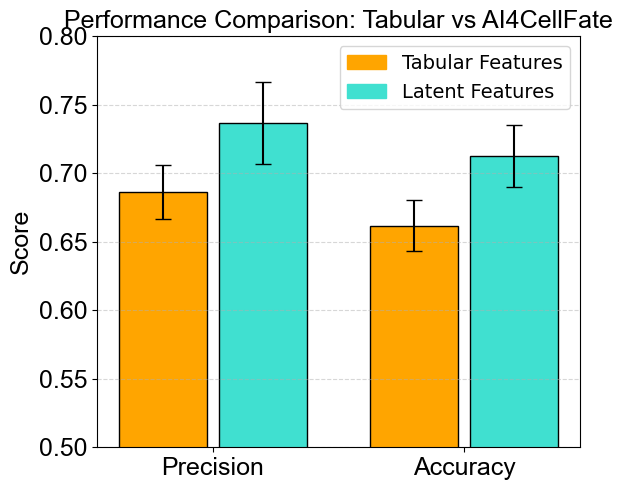

In [98]:
means_precision = [precision_tabular.mean(), precision_ai4cellfate.mean()]
std_precision = [precision_tabular.std(), precision_ai4cellfate.std()]
means_accuracy = [accuracy_tabular.mean(), accuracy_ai4cellfate.mean()]
std_accuracy = [accuracy_tabular.std(), accuracy_ai4cellfate.std()]

# X positions for bars (closer together)
x = np.array([0, 0.8])  # Precision bars
x2 = x + 2.0  # Accuracy bars (closer spacing)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))

# Define bar width
bar_width = 0.7

# Bar plots with error bars
ax.bar(x, means_precision, yerr=std_precision, capsize=6, color=["orange", "turquoise"], edgecolor='black', width=bar_width, label="Precision")
ax.bar(x2, means_accuracy, yerr=std_accuracy, capsize=6, color=["orange", "turquoise"], edgecolor='black', width=bar_width, label="Accuracy")

# X-axis labels centered
ax.set_xticks([0.4, 2.4])  
ax.set_xticklabels(["Precision", "Accuracy"], fontsize=16, fontname='Arial')

# Y-axis label
ax.set_ylabel("Score", fontsize=18, fontname='Arial')

# Y-axis ticks (bigger font)
ax.tick_params(axis='y', labelsize=18)

# Title
ax.set_title("Performance Comparison: Tabular vs AI4CellFate", fontsize=18, fontname='Arial')

# Legend (top right with correct colors)
legend_labels = ["Tabular Features", "Latent Features"]
legend_colors = ["orange", "turquoise"]
legend_patches = [plt.Rectangle((0,0),1,1, color=color, edgecolor='black') for color in legend_colors]
ax.legend(legend_patches, legend_labels, loc="upper right", fontsize=14)

# Set y-axis limit
ax.set_ylim(0.5, 0.8)

plt.xticks(fontsize=18, fontname="Arial")
plt.yticks(fontsize=18, fontname="Arial")

# Grid
ax.yaxis.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
#plt.savefig("barplot_all_feat_comparison.eps", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/ds/_m8m03r135b5r67hc6xgtxt00000gn/T/ipykernel_28877/2293490691.py:37: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_patches = [plt.Rectangle((0,0),1,1, color=color, edgecolor='black') for color in legend_colors]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


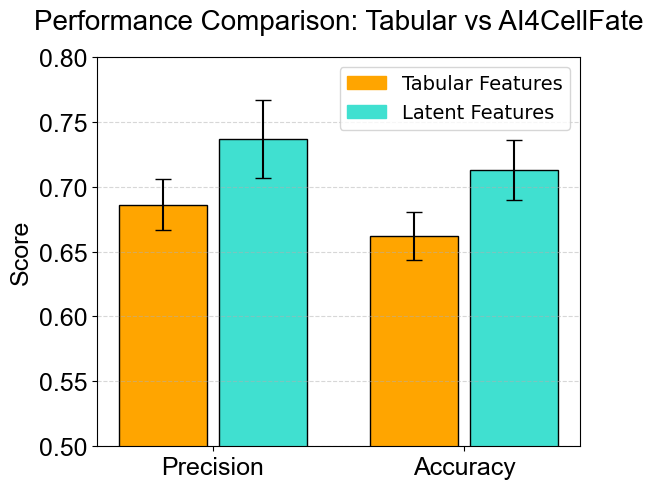

In [104]:
# Compute means and standard deviations
means_precision = [precision_tabular.mean(), precision_ai4cellfate.mean()]
std_precision = [precision_tabular.std(), precision_ai4cellfate.std()]
means_accuracy = [accuracy_tabular.mean(), accuracy_ai4cellfate.mean()]
std_accuracy = [accuracy_tabular.std(), accuracy_ai4cellfate.std()]

# X positions for bars (closer together)
x = np.array([0, 0.8])  # Precision bars
x2 = x + 2.0  # Accuracy bars (closer spacing)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))

# Define bar width
bar_width = 0.7

# Bar plots with error bars
ax.bar(x, means_precision, yerr=std_precision, capsize=6, color=["orange", "turquoise"], edgecolor='black', width=bar_width, label="Precision")
ax.bar(x2, means_accuracy, yerr=std_accuracy, capsize=6, color=["orange", "turquoise"], edgecolor='black', width=bar_width, label="Accuracy")

# X-axis labels centered
ax.set_xticks([0.4, 2.4])  
ax.set_xticklabels(["Precision", "Accuracy"], fontsize=16, fontname='Arial')

# Y-axis label
ax.set_ylabel("Score", fontsize=18, fontname='Arial')

# Y-axis ticks (bigger font)
ax.tick_params(axis='y', labelsize=18)

# Title with extra spacing
ax.set_title("Performance Comparison: Tabular vs AI4CellFate", fontsize=20, fontname='Arial', pad=20)

# Legend (top right with correct colors)
legend_labels = ["Tabular Features", "Latent Features"]
legend_colors = ["orange", "turquoise"]
legend_patches = [plt.Rectangle((0,0),1,1, color=color, edgecolor='black') for color in legend_colors]
ax.legend(legend_patches, legend_labels, loc="upper right", fontsize=14)

# Set y-axis limit
ax.set_ylim(0.5, 0.8)

plt.xticks(fontsize=18, fontname="Arial")
plt.yticks(fontsize=18, fontname="Arial")

# Grid
ax.yaxis.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("barplot_all_feat_comparison.eps", dpi=300, bbox_inches="tight")
plt.show()

## And now with the exact same model between tabular features and latent features

In [73]:
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

conf_matrix_tabular_simple = np.zeros((3, 2, 2)) # 3 random states, 11 time points, 2x2 confusion matrix

for seed in [42, 43, 44]:

    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
    class_weights = dict(enumerate(class_weights))

    tf.keras.utils.set_random_seed(seed)
    np.random.seed(seed)

    # using same model as we use for the latent features
    classifier = mlp_classifier(latent_dim=train_tracks_features[:,:].shape[1]) #[:, [3, 8]] 
    #classifier = simple_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1])

    # Train the classifier
    classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
    classifier.summary()

    x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_features[:,:], test_labels, test_size=0.5, random_state=42) # 42 random state

    history = classifier.fit(train_tracks_features[:,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) 

    y_pred = classifier.predict(x_test_tracks)

    num_classes = 2
    threshold = 0.5
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_tracks, y_pred_classes)

    class_sums = cm.sum(axis=1, keepdims=True)
    conf_matrix_normalized = cm / class_sums

    print(conf_matrix_normalized)

    conf_matrix_tabular_simple[seed-42] = conf_matrix_normalized


Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_97 (Dropout)            │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28 (112.00 B)

 Trainable params: 28 (112.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6455 - loss: 310.4450 - val_accuracy: 0.8116 - val_loss: 23.1982
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.6249 - loss: 232.7152 - val_accuracy: 0.2536 - val_loss: 67.3228
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.5118 - loss: 233.5694 - val_accuracy: 0.3261 - val_loss: 37.6426
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - accuracy: 0.5286 - loss: 232.6502 - val_accuracy: 0.3696 - val_loss: 30.9210
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.4988 - loss: 253.1135 - val_accuracy: 0.3043 - val_loss: 36.3812
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.5209 - loss: 168.1858 - val_accuracy: 0.3478 - val_loss: 32.5501
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.5278 - loss: 168.5726 - val_accuracy: 0.5580 - val_loss: 18.8712
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.5638 - loss: 184.67

Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_98 (Dropout)            │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28 (112.00 B)

 Trainable params: 28 (112.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1842 - loss: 643.1882 - val_accuracy: 0.1304 - val_loss: 800.1771
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.2174 - loss: 435.6574 - val_accuracy: 0.1304 - val_loss: 467.3619
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.2690 - loss: 258.5133 - val_accuracy: 0.1812 - val_loss: 181.0352
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.3589 - loss: 160.4789 - val_accuracy: 0.5580 - val_loss: 44.7783
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.5486 - loss: 111.9816 - val_accuracy: 0.6522 - val_loss: 32.7566
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.5720 - loss: 85.1665 - val_accuracy: 0.6594 - val_loss: 30.1120
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.5797 - loss: 95.0890 - val_accuracy: 0.7101 - val_loss: 24.7012
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.5963 - loss: 80.91

Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_99 (Dropout)            │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28 (112.00 B)

 Trainable params: 28 (112.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3171 - loss: 1045.2083 - val_accuracy: 0.1304 - val_loss: 1535.9468
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.3314 - loss: 930.7383 - val_accuracy: 0.1304 - val_loss: 1229.4744
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.3413 - loss: 814.8987 - val_accuracy: 0.1304 - val_loss: 924.1481
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.3430 - loss: 670.6949 - val_accuracy: 0.1304 - val_loss: 633.3793
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - accuracy: 0.3641 - loss: 588.0195 - val_accuracy: 0.1304 - val_loss: 356.6758
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.3844 - loss: 463.6930 - val_accuracy: 0.1522 - val_loss: 107.8822
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - accuracy: 0.4850 - loss: 377.5350 - val_accuracy: 0.5072 - val_loss: 19.7939
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - accuracy: 0.4989 - los

In [79]:
# get precision and accuracy for both cases

precision_tabular_simple = np.zeros((conf_matrix_tabular_simple.shape[0]))
accuracy_tabular_simple = np.zeros((conf_matrix_tabular_simple.shape[0]))
false_positives_tabular_simple = np.zeros((conf_matrix_tabular_simple.shape[0]))
false_negatives_tabular_simple = np.zeros((conf_matrix_tabular_simple.shape[0]))

for seed in range(conf_matrix_tabular_simple.shape[0]):
    conf_matrix = conf_matrix_tabular_simple[seed]
    print(conf_matrix.shape)
    precision_tabular_simple [seed] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
    accuracy_tabular_simple [seed] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
    false_positives_tabular_simple [seed] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
    false_negatives_tabular_simple [seed] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])



(2, 2)
(2, 2)
(2, 2)


In [82]:
accuracy_tabular_simple

array([0.5       , 0.53539254, 0.61261261])